#Connect to Google drive to access DataSet
*   import **drive module** from **google.colab package**.
*   mount/link google drive in underlying ubuntu instance/os file system of google colab.
*   change from current directory to given directory. To run linux command prefix with % or ! in google colab
* Ensure path of dataset should be correct









In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Covid19/Database2/'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ClXg6cPY6SnMUClSeqeCwcK0q7v3TXX6/Covid19/Database2


# Import required moudules and classes
* from os module we used listdir function to get list of dirs from given directory path
* from glob module, we used glob function to read all files from given path
* from cv2 module, we used imread,cvtcolor,resize function
* from np module, we used array and concatenate function
* from matploltlib.pyplot module, subplots,show.. functions used
* Other modules/functions and classes used from remaining modules are used directly such as train_test_split function, LabelBinarizer class etc.


In [ ]:
import os
from glob import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import Xception

from builtins import range, input

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import roc_curve
import seaborn as sns

# Define Parameters
Here we have defined standard image size required for our model i.e. 299x299 (all images will be resized to 299x299).

Defined no. of epochs and batch size required for model training.

Defined path of Positive and Negative Images and read list of subdirs


In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [299, 299]

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'Positive' 
noncovid_path = 'Negative'
covid_dir=os.listdir(covid_path)  # read sub dirs from covid path and store subdir list in covid_dir
noncovid_dir=os.listdir(noncovid_path)


#Fetch Images and Class Labels
Fetch all covid images and store in covid_images list and their label i.e. "positive" store into covid_labels list

In [ ]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for cpath in covid_dir:
  # Use glob to grab images from path .jpg or jpeg
  covid_files = glob(covid_path+"/"+cpath + '/*')
  for i in range(len(covid_files)):
    if i>20:
      break
    image = cv2.imread(covid_files[i]) # read file 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
    image = cv2.resize(image,(299,299)) # resize as per model
    covid_images.append(image) # append image
    covid_labels.append('Positive') #append class label

for ncpath in noncovid_dir:
  noncovid_files = glob(noncovid_path+"/"+ncpath + '/*')    
  for i in range(len(noncovid_files)):
    if i>20:
      break
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(299,299))
    noncovid_images.append(image)
    noncovid_labels.append('Negative')

In [ ]:
print("length of covid: ",len(covid_images))
print("length of noncovid: ",len(noncovid_images))

length of covid:  945
length of noncovid:  231


# Visualize Few Images

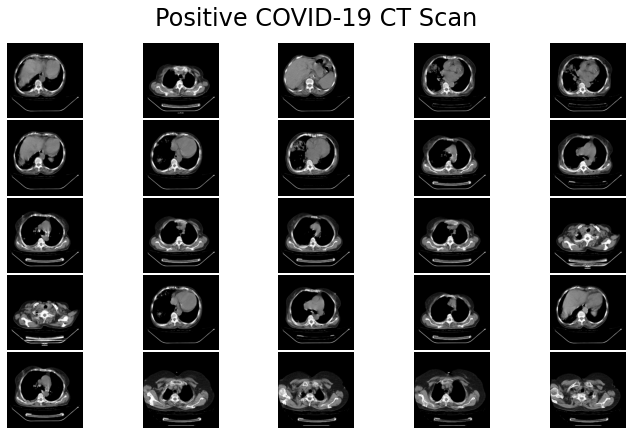

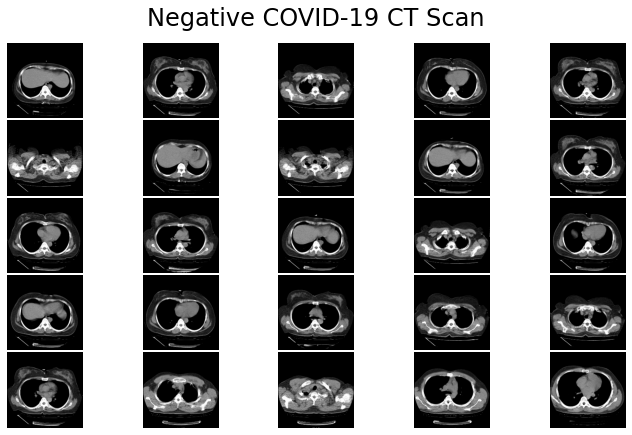

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 5
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

# Normalization
To input images to our model, we must convert into numpy array and normalize it.

In [ ]:
# Convert to images to num array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

# Train Test Split

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2) # Training Size=> 80% and Testing Size=>20%
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split( 
    noncovid_images, noncovid_labels, test_size=0.2) # Training Size=> 80% and Testing Size=>20%

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

ValueError: ignored

# Visualize Images from Training and Testing

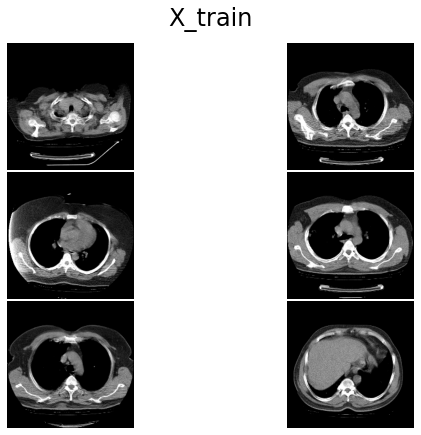

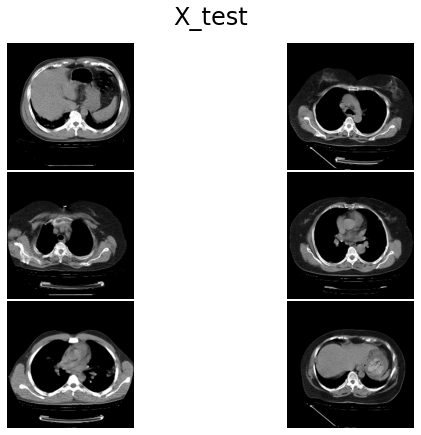

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

# Building Model

We have used transfer learning based CNN to build model i.e. extend an existing pretrained model (which already trained for million of images). We used **Xception** is a convolutional neural network that is 71 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299. 

More information can be found <a href="https://keras.io/api/applications/xception/">here</a>

In [ ]:
# Building Model
# The images in the dataset were of different sizes. Thus, fisrt resize them to a fixed size before they can be fed to 
# the deep learning models for training. We resized the images to a size of 299 x 299 px which is considered to be the 
# ideal size for the Xception model. Therefore, I added the input tensor of shape (299, 299 , 3) to the pretrained Xception
# model, 3 being the number of channels [R B G].
xception = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(299, 299, 3)))

outputs = xception.output
# We first added 3 custom layers to the pretrained models so that they can be trained on our dataset.
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

# Next, added a Flatten layer to flatten all our features and a Dropout layer to overcome overfitting. Finally, added the 
# Dense output layer using softmax function as the activation function. 
# Since the first half of the model is already pretrained, the trainable attribute of the previous layers was set to False. 

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)
# Finally, compiled the model with the adam optimizer and using categorical crossentropy as the loss function.


83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 114, 114, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 114, 114, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
# Data Augmentation
# ImageDataGenerator used to train the models at modified versions of the images, such as at different angles, flips, rotations or shifts.
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Training the model

In [ ]:
# Next, training of the model was performed, with all the required parameters specified as follows:
# We have trained the model for 500 epochs with a batch size of 32 images.
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
29/29 [==============================] - 26s 427ms/step - loss: 2.9629 - accuracy: 0.7191 - val_loss: 1.0324 - val_accuracy: 0.7924
Epoch 2/500
29/29 [==============================] - 12s 404ms/step - loss: 1.3236 - accuracy: 0.7713 - val_loss: 0.9563 - val_accuracy: 0.7500
Epoch 3/500
29/29 [==============================] - 11s 389ms/step - loss: 1.4280 - accuracy: 0.7479 - val_loss: 0.4239 - val_accuracy: 0.8644
Epoch 4/500
29/29 [==============================] - 13s 442ms/step - loss: 1.8428 - accuracy: 0.7596 - val_loss: 1.4234 - val_accuracy: 0.8390
Epoch 5/500
29/29 [==============================] - 11s 388ms/step - loss: 1.7878 - accuracy: 0.7553 - val_loss: 1.1969 - val_accuracy: 0.8390
Epoch 6/500
29/29 [==============================] - 12s 393ms/step - loss: 1.2794 - accuracy: 0.8223 - val_loss: 1.1996 - val_accuracy: 0.8305
Epoch 7/500
29/29 [==============================] - 12s 391ms/step - loss: 1.4049 - accuracy: 0.8021 - val_loss: 0.8917 - val_accuracy:

In [ ]:
# Save Model and Weights to our google drive folder as xception_ct.h5 and xception_weights_ct.hdf5 file
model.save('/content/drive/My Drive/Covid19/xception_ct.h5')
model.save_weights('/content/drive/My Drive/Covid19/xception_weights_ct.hdf5')

In [ ]:
# Load saved model
model = load_model('/content/drive/My Drive/Covid19/xception_ct.h5')

# Making Predictions

In [ ]:
# Predictions were generated by running the trained models on images of the test set. 
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
# Visualizing First 10 Predictions

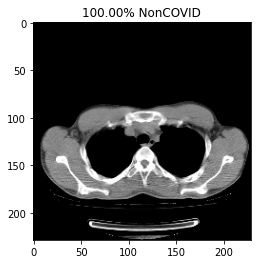

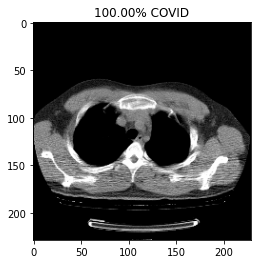

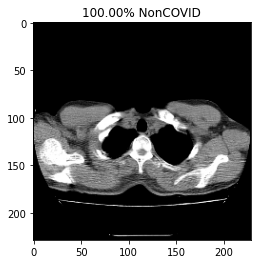

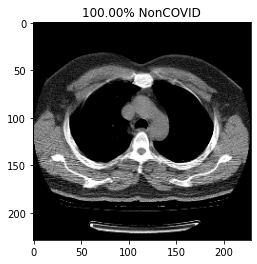

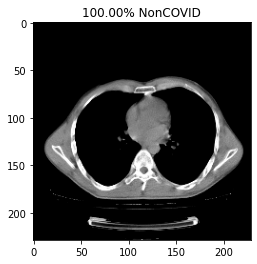

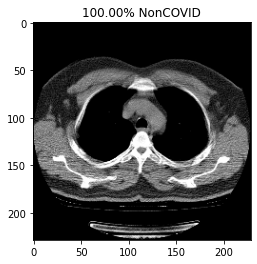

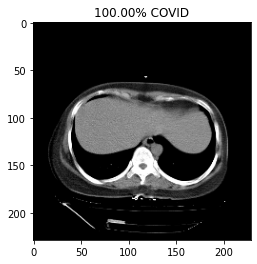

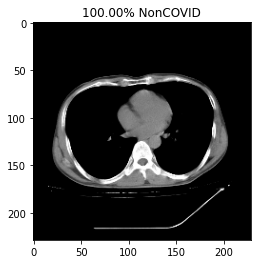

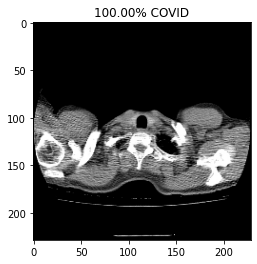

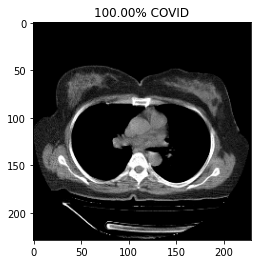

In [ ]:
# The predictions for the first 10 images of the dataset were plotted as shown below:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

# Plot ROC Curve

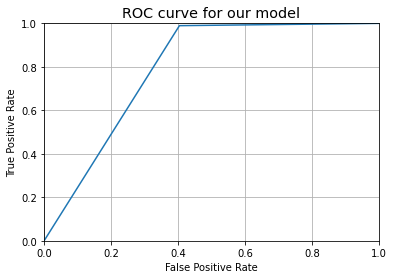

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)